In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf, sys
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print('tensorflow version: %s' % tf.__version__)
print('python version: %s' % sys.version)
print('python executable location: %s' % sys.executable)

# --------------------------------------------------------------
# --------------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np

from helpers import *
import os, sys, tarfile, time
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator
import pickle
import pandas as pd

params = {'legend.fontsize': 'x-large',
          'font.size'      : 11,
          'figure.figsize' : (17, 6),
          'axes.labelsize' : 'x-large',
          'axes.titlesize' : 'x-large',
          'axes.grid'      : 'on',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

pylab.rcParams.update(params)


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8346499012792049175
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 279052288
locality {
  bus_id: 1
}
incarnation: 10307374538300732891
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]
tensorflow version: 1.0.0
python version: 3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
python executable location: /home/aind2/anaconda3/envs/aind-dog/bin/python


In [5]:
df_funding = pd.read_csv('data/funding.csv')
df_startup = pd.read_csv('data/startup.csv')
df_investors = pd.read_csv('data/investor.csv')
df_affiliations = pd.read_csv('data/affiliations.csv')


In [6]:
df_affiliations[:5]

,id,name,num_affiliated_founders
0,7e9709a7-3747-408a-b86a-30dc62ec15bf,Academic Earth,1
1,5b5ff3bf-b28d-418e-874b-d7f4c62877bc,Mixed Dimensions,1
2,368ffacf-c567-4ceb-a4fb-e7ad216674bd,ipadio,1
3,51aae8b3-ddbc-457b-a599-8d69de9a37bf,CTERA Networks,1
4,c81fcf1a-3418-4d4a-9eec-3c6aa7af7786,Cypromus,1


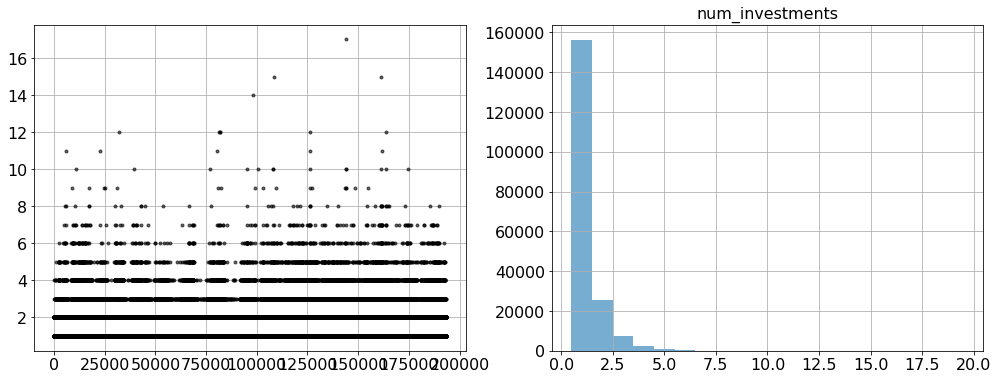

In [11]:
a = df_funding['num_investments'].as_matrix()
plt.figure()
ax = plt.subplot(121)
ax.plot(a, 'k.', alpha=.6)

# .............................................

ax = plt.subplot(122)
ax.hist(a, bins=np.linspace(.5,19.5,20), alpha=.6);
ax.set_title('num_investments')


In [ ]:
50000

In [8]:
gr_inv = df_funding.groupby(by='investor_id').groups
gr_sta = df_funding.groupby(by='startup_id').groups

invID_to_i = {}
staID_to_j = {}
i_to_invID = {}
j_to_staID = {}

#.............................
i = -1
for k,v in gr_inv.items():
    i = i + 1
    invID_to_i[k] = i
    i_to_invID[i] = k
    
j = -1
for k,v in gr_sta.items():
    j = j + 1
    staID_to_j[k] = j
    j_to_staID[j] = k
#.............................
n_investments, n_investors, n_startups = (len(df_funding), len(invID_to_i), len(staID_to_j))

print('n_investments: \t%i' % (n_investments,)) 
print('n_investors: \t%i' % (n_investors,)) 
print('n_startups: \t%i' % (n_startups,)) 

n_investments: 	193341
n_investors: 	41838
n_startups: 	64764



### Obtain `R` and `R_indices`:

In [6]:
df_funding['i'] =  df_funding['investor_id'].apply(lambda row: invID_to_i[row])
df_funding['j'] =  df_funding['startup_id'].apply(lambda row: staID_to_j[row])
R_indices = df_funding[['i', 'j']].as_matrix()
R = np.ones(len(R_indices))
print('R.shape: %a \nR_indices.shape: %a' % (R.shape, R_indices.shape))

R.shape: (193341,) 
R_indices.shape: (193341, 2)


### Randomly sample indices of N/A entries in matrix `R`, then load the data into `R0_indices` and `R0=0`.
### Then, find `R0_indices` where there's collisions with `R_indices`.

In [7]:
# zero_examples = len(R)*10
# R0 = np.zeros((zero_examples))
# R0_indices = np.zeros((zero_examples, 2), dtype=np.int64)
# R0_indices[:,0] = np.random.choice(n_investors, zero_examples) 
# R0_indices[:,1] = np.random.choice(n_startups, zero_examples) 

# # This cell takes 60 min to run.
# start = time.time()
# collision_i = []

# for i, row in enumerate(R0_indices):
#     a = np.equal(row, R_indices)
#     if np.round(np.mean(a, axis=1)).astype('bool').any():
#         # checks if there's any row of R0_indices which is equal to some row of R_indices.
#         o = print_runtime(start,p_flag=False)
#         print('' + o)
#         print('collision detected at i: %i, row: %a' % (i, row))
#         collision_i.append(i)

# # .....................................................
# with open('data/collision_i.pkl', 'wb') as f:
#     pickle.dump(collision_i, f, pickle.HIGHEST_PROTOCOL)
# with open('data/R0_indices.pkl', 'wb') as f:
#     pickle.dump(R0_indices, f, pickle.HIGHEST_PROTOCOL)

# print_runtime(start)
# # .....................................................
# # .....................................................
# # .....................................................

with open('data/collision_i.pkl', 'rb') as f:
    collision_i = pickle.load(f)
    
with open('data/R0_indices.pkl', 'rb') as f:
    R0_indices = pickle.load(f)

""" Set the following exceptions in R0 to 1:
     R0[collision_i[...]] = 1"""

# correct the R0 vector where there are collisions with R.
R0 = np.zeros(len(R0_indices))
for i in collision_i:
    R0[i] = 1

R0 = R0[:len(R)*2]
R0_indices = R0_indices[:len(R)*2]

### Shuffle and Split Data:

In [8]:
data_R_indices, data_R = shuffler(np.concatenate((R_indices, R0_indices)), np.concatenate((R, R0)))
train_R_indices, train_R, cv_R_indices, cv_R, test_R_indices, test_R = split_data(data_R_indices, data_R)
print('train_R_indices.shape: \t%a' % (train_R_indices.shape,))
print('cv_R_indices.shape: \t%a' % (cv_R_indices.shape,))
print('test_R_indices.shape: \t%a' % (test_R_indices.shape,))

train_R_indices.shape: 	(371214, 2)
cv_R_indices.shape: 	(92804, 2)
test_R_indices.shape: 	(116005, 2)


# Matrix Factorization Model
### Training:

In [63]:
LAMBDA = 0.000
BATCH_SIZE = 256
lr = 0.001
k = 10 
NUM_EPOCHS = 10 

#.............................................. 
start = time.time()
print('Start: construct_graph()... ', end='\r')
train, loss, reg, R_indices, R, U, V, R_pred, X_UV = \
                        construct_graph(LAMBDA, k, lr, BATCH_SIZE, n_investors, n_startups, cui=0.1)
o = print_runtime(start, p_flag=False)
print('Finished: construct_graph()... ' + o)
#.............................................. 

start = time.time()
mae_cv_arr, mae_test_arr, loss_arr = train_the_model(R_indices, R, train_R_indices, 
                train_R, BATCH_SIZE, 
                NUM_EPOCHS, LAMBDA, k, lr, 
                train, loss, reg, U, V, X_UV, R_pred,
                cv_R, cv_R_indices, test_R, test_R_indices, threshold=0.8)
#.............................................. 
# plotting....
plotter(mae_cv_arr, loss_arr, BATCH_SIZE)

#.............................................. 
print_runtime(start)
# os.system('afplay System/Library/Sounds/Ping.aiff')

Finished: construct_graph()... Runtime: 0 min 3 sec
NUM_EPOCHS: 10
LAMBDA: 0.0
k: 10
lr: 0.001
n_batches: 1450
BATCH_SIZE: 256
start SGD iterations...
Epoch 1 _________________________________________________________________________
batch_no: 1450, _loss estimate: 0.2284, t= 23.04 sec
mae_train: 0.5224, **mae_cv: 0.5373**, mae_test: 0.5406,  CHECKPOINT!!, f1_score_cv: 0.6299
Epoch 2 _________________________________________________________________________
batch_no: 1450, _loss estimate: 0.2049, t= 27.08 sec
mae_train: 0.4247, **mae_cv: 0.4749**, mae_test: 0.4769,  CHECKPOINT!!, f1_score_cv: 0.6655
Epoch 3 _________________________________________________________________________
batch_no: 1450, _loss estimate: 0.1785, t= 27.17 sec
mae_train: 0.3222, **mae_cv: 0.4143**, mae_test: 0.4154, f1_score_cv: 0.6526
Epoch 4 _________________________________________________________________________
batch_no: 1450, _loss estimate: 0.1538, t= 22.56 sec
mae_train: 0.2508, **mae_cv: 0.3680**, mae_test:

KeyboardInterrupt: 

### Restore session variables from disk:

In [64]:
### Restore session variables from disk.

start = time.time()
# .................................................
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "saved_models/MF_models/best_model.ckpt") 
preds_test, _mae_test = evaluate_preds_and_mae(sess, test_R, test_R_indices, R_pred, R_indices, R, BATCH_SIZE)
preds_cv, _mae_cv = evaluate_preds_and_mae(sess, cv_R, cv_R_indices, R_pred, R_indices, R, BATCH_SIZE)

sess.close()
# .................................................
print_runtime(start) 

Runtime: 0 min 7 sec


/home/aind2/miscelleneous_projects/VentureHub/helpers.py:61: RuntimeWarning: invalid value encountered in double_scalars
  precision = tp/float(tp+fp)


precision_cv: 0.688
recall_cv: 0.660 <==
f1_score_cv: 0.674


<IPython.core.display.Latex object>

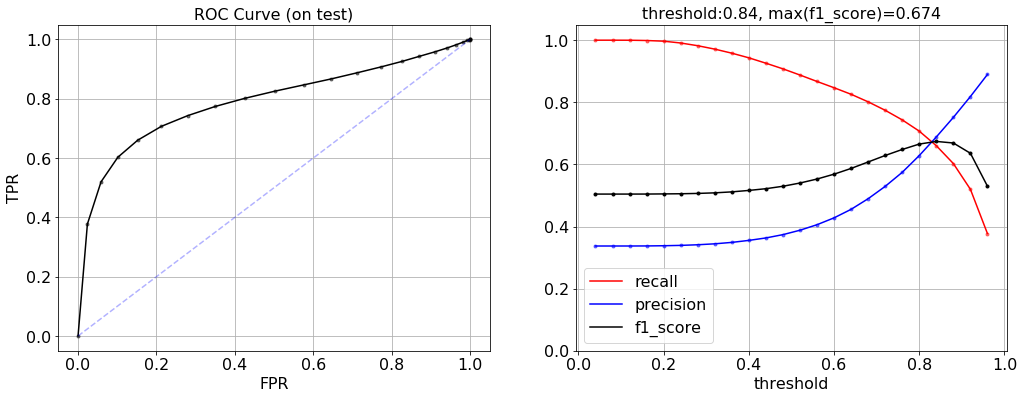

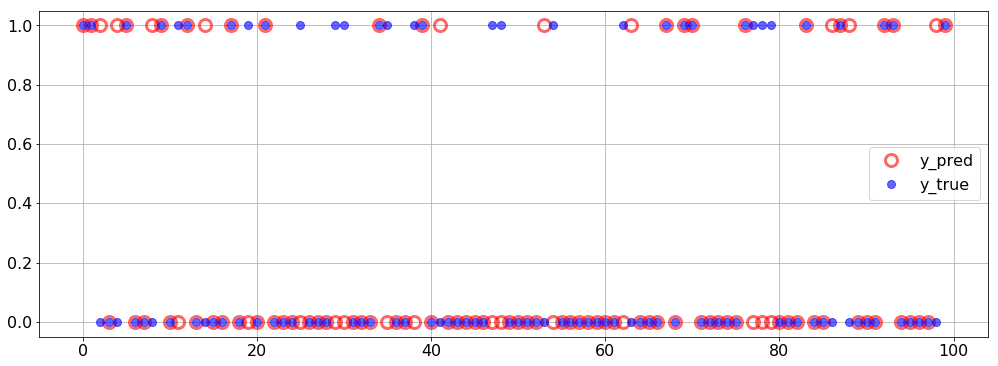

In [72]:
### Calculate and plot, precision, recall, f1_score and ROC curve.

_, accuracy, precision, recall, f1_score, fpr = return_ROC_statistics(preds_cv, cv_R )

idx = np.nanargmax(f1_score)
f1_score[idx]

# ................................................................

ax = plt.subplot(121)
ax.plot(fpr, recall, 'k')
ax.plot(fpr, recall, 'k.', alpha=.5)
ax.plot([0,1], [0,1],'b--', alpha=.3)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve (on test)')

ax = plt.subplot(122)
threshold = np.linspace(0,1,len(precision))
ax.plot(threshold[1:-1], recall[1:-1], 'r')
ax.plot(threshold[1:-1], precision[1:-1], 'b')
ax.plot(threshold[1:-1], f1_score[1:-1], 'k')
ax.set_ylim((0,1.05))
ax.set_xlabel('threshold')
ax.set_title('threshold:{:3.2f}, max(f1_score)={:5.3f}'.format(threshold[idx], f1_score[idx]))
ax.legend(['recall', 'precision','f1_score']);
ax.plot(threshold[1:-1], recall[1:-1], 'r.', alpha=.5)
ax.plot(threshold[1:-1], precision[1:-1], 'b.', alpha=.5)
ax.plot(threshold[1:-1], f1_score[1:-1], 'k.')
#.........................................
y_pred_cv_01, _, precision_cv, recall_cv, f1_score_cv, _ = return_ROC_statistics(
                                                preds_cv, cv_R, threshold=threshold[idx]) 
print('precision_cv:{:6.3f}\nrecall_cv:{:6.3f} <==\nf1_score_cv:{:6.3f}'.format(
                    precision_cv, recall_cv, f1_score_cv))

# ............................................................................
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(y_pred_cv_01[:100],'ro', alpha=.6, markersize=12,  markerfacecolor='None', markeredgewidth=3)
ax.plot(cv_R[:100],'b.', alpha=.6, markersize=16)
ax.legend(('y_pred', 'y_true'), loc='right') 
# ............................................................................

from IPython.display import Markdown, Latex
Latex('$$precision = \\frac{tp}{tp+fp}$$ $$$$ $$recall = \\frac{tp}{tp+fn}$$')


> ### Comparison between Linear and Cross Feature Models:   
   
  
> - `BATCH_SIZE = 256`  
Linear Model: `25 sec/epoch`     
Cross-Feature Model: `90 sec/epoch`  
  
  
> - Linear Feature Model, though, can achieve smaller `MAE_cv=0.1326` (`@epoch10`), but produces worse `recall_cv=0.515`. 
  
  
> - Cross Feature Model achieves `recall_cv=0.618` and  `MAE_cv=0.1740` (`@epoch8`).
  
  
> -  Linear Feature Model loss function is minimized smoothly. However, Cross Feature Model loss function is very jagged and jumpy. Might try optimizing Cross Feature Model with a smaller `lr=0.001` !!! 
  
  
> - Cross Features Model with a smaller learning rate `lr=0.001`, achieves much smaller `MAE_cv=0.1608` (`@epoch10`) but not a totally satisfactory recall `recall_cv: 0.586`.  
But `mae_cv` is's still dropping. Need to start training from saved model and run it for another 10 epochs.
  
  

  

> ### TO DO:
> - `train_the_model()`: restore session with   
  `saver.restore(sess, "saved_models/best_model.ckpt")`   
  instead of creating one with:   
  `with tf.Session() as sess:`
  
  
> - add a flag to `train_the_model(restore=False)`. If `(sess=sess, restore=True)` than skip creating a new `sess`
  
  
> - save `best_model.ckpt` accoprding to `f1_score` instead of `mae_cv` or `recall_cv`.